In [ ]:
# Ideas to add to the proposal:
# 1. trend analysis might be possible if we do it for each year. 
# 2. we might turn it to simulation problem in the area of ASHDOD ASHKELON. In case a factor is asspcoated with 
# Rotenberg's plant then I might try and guess their hourly/daily emission rates by an optimization and gaussian model (or even ODM)
# and to see if it makes sence according to MOEP inventory. 
# Can I also do it with cars?
# 3. improve the ODM with wind field that is not uniform? 
# 4. show comparison of traffic estimation between ATZMAUT FA and NMF. 
# 5. should also try again the LR YOM-KIPUR with NMF. was also interesting, maybe better results after better imputation, and per area. 
# 6. distribution of concentrations related to the different factors in one station

In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm
import matplotlib.gridspec as gridspec
from factanal.wrapper import factanal
import json
import seaborn as sns

import geopandas as gp
import descartes
# import geoplot

# import geoplot.crs as gcrs

from scipy import signal
from sklearn.decomposition import FastICA, PCA

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import zscore

from sklearn.decomposition import non_negative_factorization, NMF

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [2]:
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [3]:
def scree_plot(ev,df):    
    plt.plot(range(1,df.shape[1]+1),ev,'-o',color='b')
    plt.title('Scree Plot')
    plt.xlabel('Number of factors')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1,c='r')
    plt.show();
       
def perform_fa(df, NUM, rotation, scores_method, method):
    
    fa = factanal(df, factors=NUM, scores=scores_method, rotation=rotation,  #'Bartlett','regression'
                  verbose=True, return_dict=True)
    
#     fa = FactorAnalyzer(n_factors=NUM, rotation=rotation, method=method) 
#     fa.fit(df)
    return fa


def loadings_plot(Loadings, col_names):
    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.pcolor(abs(Loadings))
    fig.colorbar(c, ax=ax)
    ax.set_yticks(np.arange(Loadings.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(Loadings.shape[1])+0.5, minor=False)
    ax.set_yticklabels(col_names)
    ax.set_xticklabels(['Factor '+str(i+1) for i in range(Loadings.shape[1])])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/loadings_4_factors.png", dpi=500)
    plt.show();   
    
def plot_map(gdf,stations): 
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    ax = gdf.plot(figsize=(10, 10),color='w',edgecolor='k')
    print(stations['factor'].unique())
    df.plot(ax=ax,c=stations['factor'])
#     plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/map_3_factors.png", dpi=500)
    for k, v in df.iterrows():
#         ax.annotate(np.round(v.max_load,2),(v.Lon,v.Lat),size=6)
        ax.annotate(v.name,(v.Lon,v.Lat),size=6)
    plt.show();
    
      
def plot_factors_and_loadings(df_scores,df_load, list_of_factors, station_names, weekend_removed, to_save):
    mpl.style.use('seaborn-white')
#     cm = ['c','m','#d9534f','#9ad801']
    cm = sns.color_palette(None, len(list_of_factors))
    
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 4)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:3])  # top left
    df_scores.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')

    ax2 = plt.subplot(grid[1,:3])   # middle left
    df_scores.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)

    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')


    ax3 = plt.subplot(grid[2,:3])  # bottom left
    
    # don't include the weekend in the plot
    df_scores[df_scores['week day'].isin([0,1,2,3,4])].groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')


    ax4 = plt.subplot(grid[0:3,3:5])  # all right

    df_load[list_of_factors].plot(kind='barh', stacked=True, color=cm,ax=ax4,legend=True)
    ax4.legend(bbox_to_anchor=(1.7, 1), loc=2 ,frameon=True)
    ax4.set_yticks(np.arange(0,len(station_names)))
    ax4.set_yticklabels(station_names)
    ax4.yaxis.tick_right()
    ax4.set_facecolor('white')
    plt.xlabel('\nLoadings')
    # plt.show();
    
    plt.rcParams.update({'font.size': 14})
    fig.tight_layout()
    if to_save:
        plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/change_name.png", dpi=500)
    
    plt.show();
    
    
def test_if_FA_suitable(df):
    
    # Bartlett’s Test - p-value should be significant
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    # Kaiser-Meyer-Olkin (KMO) Test - between 0 and 1 - when 1 is highly suitable for factor analysis
    kmo_all,kmo_model=calculate_kmo(df)
    return p_value, kmo_model
    
    
def add_group_columns_to_df_scores(df_scores,times):
    df_scores['datetime'] = pd.to_datetime(times['time'], format='%Y-%m-%d %H:%M')
    df_scores['month'] = pd.to_datetime(times['time']).dt.month
    df_scores['hour'] = pd.to_datetime(times['time']).dt.hour
    df_scores['minute'] = pd.to_datetime(times['time']).dt.minute
    df_scores['Day in year'] = pd.to_datetime(times['time']).dt.dayofyear
  
    df_scores['week day'] = pd.to_datetime(times['time']).dt.dayofweek+1
#     print(df_scores['week day'].unique())
    df_scores.loc[df_scores['week day']==7,'week day']=0
#     print(df_scores['week day'].unique())
    
    return df_scores

def plot_time_series_sections(df,list_of_factors,times,weekend_removed):
    
    df = add_group_columns_to_df_scores(df,times)
    cm = sns.color_palette(None, len(list_of_factors))
    
    mpl.style.use('seaborn-white')
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 1)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:1])  # top left
    df.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
#     plt.ylim([-100,100])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc=2 ,frameon=True)

    ax2 = plt.subplot(grid[1,:1])   # middle left
    df.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)
    
    
    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')

    ax3 = plt.subplot(grid[2,:1])  # bottom left
    df[df['week day'].isin([0,1,2,3,4])].groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')

    fig.tight_layout()
    plt.show();
    
    
    
def get_FA_results(df, times,  NUM, rotation, gdf, weekend_removed, show_factors, to_save, scores_method):

    mpl.style.use('default')
#     print(test_if_FA_suitable(df))
    
#     # scree plot
#     fa = FactorAnalyzer()
#     fa.fit(df)
#     ev, _ = fa.get_eigenvalues()
#     scree_plot(ev,df)
    
#     df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
    
    # FA
    fa = perform_fa(df, NUM, rotation, scores_method, method = 'ml')
    
#     # print cummulative variance
#     print(fa.get_factor_variance())

    # print uniqueneses
#     print(fa['uniquenesses'])
    
    # plot loadings 
#     # with factorAnalyzer()
#     Loadings = fa.loadings_
#     scores = fa.transform(df) # numerical value, no units

    # with factanal (R)
    Loadings = np.array(fa['loadings'])
    scores = np.array(fa['scores']) # numerical value, no units
    rotmat = []
#     if rotation == 'none':
#         rotmat = []
#     else: 
#         rotmat = np.array(fa['rotmat'])
    
    col_names = df.columns
#     loadings_plot(Loadings, col_names)
    
#     # plot stations  
#     # ascribe a factor to each station based on max loading value (and show it on map)
#     stations = stations[stations.name.isin(df.columns)]
#     stations['factor'] = np.argmax(abs(Loadings),axis=1)+1
#     stations['max_load'] = np.max(abs(Loadings),axis=1)
#     plot_map(gdf,stations)
    
    # plot factors and loadings 
    FACTOR_COLUMNS = ['F'+str(i+1) for i in range(NUM)]
    
    if (show_factors == 'all'): 
        list_of_factors = FACTOR_COLUMNS      
#         print('Hi')
    else:
        list_of_factors = show_factors
        
    
    df_load = pd.DataFrame(Loadings,columns=FACTOR_COLUMNS)
    df_scores = pd.DataFrame(scores, columns=FACTOR_COLUMNS)
#     print(df_scores.index)
#     print(times.index)
    df_scores = add_group_columns_to_df_scores(df_scores,times)
#     print(df_scores.head())
#     print(df_scores['week day'].unique())


#     # UNSTANDARDIZE FACTORS
#     for i in range(NUM):
#         df_scores.iloc[:,i] = df.mean(axis=1) + df.std(axis=1)*df_scores.iloc[:,i].values
    
    plot_factors_and_loadings(df_scores,df_load, list_of_factors, df.columns, weekend_removed, to_save)
    plt.rcParams.update({'font.size': 14})
    
    return rotmat, Loadings, scores



In [4]:
def initialize():
#     df = pd.read_csv("~/Documents/saved_data_from_notebooks/RF_add1_fixed_2012_2019.csv")
#     times = pd.read_csv("~/Documents/saved_data_from_notebooks/times_df_2012_2019.csv")
    times = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/times_df_2012_2019.csv")
#     df = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/RF_add1_fixed_2012_2019.csv")
    df = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/final_imputed_df_mix")
    
    to_keep = ['ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'PETAH_TIKVA_ROAD', 'REMEZ',
       'YAD_LEBANIM', 'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KAKAL',
       'KIRYAT_ATA', 'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON',
       'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN', 'EFRATA', 'NAVE_ILAN',
       'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'DALYA', 'GEDERA', 'GVARAAM',
       'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV',
       'YAHALOM', 'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'HEFZIBA',
       'PARDES_HANA', 'RAANANA']  
    
    df = df.loc[:,df.columns.isin(to_keep)]
    
#     df.drop(columns = 'Unnamed: 0',inplace=True)
    times.drop(columns = 'Unnamed: 0',inplace=True)
    times.rename({'0': 'time'}, axis = 'columns',inplace=True)
    
    # NOTE THIS STATION FILE WAS GENERATED FOR 34 STATIONS OF 2013-2018
    stations = pd.read_csv("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/stations_info_38.csv")
#     gdf = gp.read_file("/home/idit/Documents/saved_data_from_notebooks/IsraelBorder.shp")
#     stations = pd.read_csv("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/stations_info.csv") 
    gdf = gp.read_file("/Users/iditbela/Documents/Broday/GIS/IsraelBorder/IsraelBorder.shp")

    return df,times,stations,gdf

## FA

In [5]:
remove_weekends = False
# chosen_months = [5,6,7]
# chosen_months = [11,12,1,2]
chosen_months = [1,2,3,4,5,6,7,8,9,10,11,12]

In [1068]:
# initialize to get times:
df,times,stations,gdf = initialize()

# choose the type of data I want to FA (i.e., REMOVE STATIONS/EXTREME EVENTS...)

# extreme events/only the dust storm
pm_threshold = 600000

# remove dust storms in 2015 and 100
time_condition = [(((times.time>='2015-02-10 00:00:00') & (times.time<='2015-02-12 23:30:00')) | ((times.time>='2015-09-07 00:00:00') & (times.time<='2015-09-12 23:30:00'))
#                   | ((times.time>='2017-01-01 00:00:00'))
#                   | ((times.time>='2015-01-06 07:30:00') & (times.time<='2015-01-08 10:00:00'))
                  | ((df.values > pm_threshold).any(axis=1))
                  )]

idx_to_drop = np.argwhere(time_condition)[:,1]
df.drop(idx_to_drop,axis = 0, inplace=True)
times.drop(idx_to_drop,axis = 0, inplace=True)


# choose months
df['month'] = pd.to_datetime(times['time']).dt.month
times = times[df.month.isin(chosen_months)]
df = df[df.month.isin(chosen_months)]
df.drop(['month'],axis = 1, inplace =True)
# reset index!
df.reset_index(inplace=True)
df.drop(labels = 'index',axis=1, inplace=True)
times.reset_index(inplace=True)
times.drop(labels = 'index',axis=1, inplace=True)

# remove stations
STATIONS_TO_DROP = []
# STATIONS_TO_DROP = 'EAST_NEGEV'
# STATIONS_TO_DROP = ['AFULA', 'KVISH4',
#        'YEFET_YAFO', 'KIRYAT_ATA', 'KIRYAT_BIALIK',  'NESHER', 'BAR_ILAN',
#        'EFRATA',  'ASHKELON_SOUTH', 'GEDERA',
#        'KIRYAT_MALAHI', 'ORT', 'ROVA_TV', 
#        'YAHALOM', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA',
#        'RAANANA']
# STATIONS_TO_DROP = ['BAR_ILAN','ATZMAUT_B','KIRYAT_BINYAMIN','KFAR_MASARIK','KIRYAT_TIVON','IRONID','KVISH4','REMEZ','YEFET_YAFO','RAANANA','EAST_NEGEV','EFRATA','AFULA','PARDES_HANA','BEER_SHEVA']

# # traffic stations:
# STATIONS_TO_DROP = ['BAR_ILAN','IRONID','KVISH4','REMEZ','YEFET_YAFO','ATZMAUT_B','RAANANA','NAVE_ILAN','KAKAL']

# # traffic and distant stations:
# STATIONS_TO_DROP = ['BAR_ILAN','IRONID','KVISH4','REMEZ','YEFET_YAFO','ATZMAUT_B','RAANANA','NAVE_ILAN','KAKAL','EFRATA','EAST_NEGEV','NAVE_ILAN','BEER_SHEVA']


# distant stations:
# STATIONS_TO_DROP = ['IRONID','BAR_ILAN','EFRATA','EAST_NEGEV']
# not in the coast:
# STATIONS_TO_DROP = ['IRONID','BAR_ILAN','EFRATA','EAST_NEGEV','BEER_SHEVA','AFULA']


# ONLY SOUTH

# STATIONS_TO_DROP = ['AHUZA_G','KAKAL','ATZMAUT_B','IRONID', 'REMEZ', 'EAST_NEGEV',
#                     'BAR_ILAN', 'ANTOKOLSKY', 'HOLON', 'KVISH4','YEFET_YAFO', 
#                      'KIRYAT_ATA', 'KIRYAT_BIALIK','KIRYAT_BINYAMIN',
#                     'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'KFAR_MASARIK', 'PARDES_HANA','HEFZIBA',
#                    'PETAH_TIKVA_ROAD', 'YAD_LEBANIM', 'EFRATA', 'NAVE_ILAN', 'RAANANA']


# # ONLY NORTH
# STATIONS_TO_DROP = ['BAR_ILAN','ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'REMEZ','NAVE_ILAN','PETAH_TIKVA_ROAD','YAD_LEBANIM','DALYA','HEFZIBA',
#        'YEFET_YAFO','EFRATA','ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI',
#        'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM',
#        'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA', 'RAANANA']#,'ATZMAUT_B','AFULA']

# # ONLY CENTER
# STATIONS_TO_DROP = ['AFULA', 'ANTOKOLSKY', 'IRONID', 'KVISH4', 'REMEZ',
#        'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK',
#        'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN',
#        'EFRATA', 'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'GEDERA', 'GVARAAM',
#        'KIRYAT_MALAHI', 'NIR_ISRAEL', 'SDEROT', 'SDE_YOAV',
#        'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'PARDES_HANA',
#        'RAANANA']# 'ORT', 'ROVA_TV'


# # REMOVE NORTH and EAST
# STATIONS_TO_DROP = ['BAR_ILAN','EFRATA','EAST_NEGEV','AHUZA_G','KAKAL','BEER_SHEVA','NAVE_ILAN',
#                     'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK','KIRYAT_BINYAMIN',
#                     'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'KFAR_MASARIK', 'PARDES_HANA','HEFZIBA']



   
    
    
    
    

# REMOVE NORTH + 'IRONID', 'REMEZ', + 'BEER_SHEVA', EAST_NEGEV? + traffic stations?
STATIONS_TO_DROP = ['AHUZA_G','KAKAL','ATZMAUT_B','IRONID', 'REMEZ', 'BEER_SHEVA',# 'EAST_NEGEV','EFRATA',
                     'KIRYAT_ATA', 'KIRYAT_BIALIK','KIRYAT_BINYAMIN',
                    'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'KFAR_MASARIK', 'PARDES_HANA','HEFZIBA',
                    'BAR_ILAN','IRONID','KVISH4','REMEZ','YEFET_YAFO','ATZMAUT_B','RAANANA','NAVE_ILAN','KAKAL']

# # REMOVE traffic
# STATIONS_TO_DROP = ['BAR_ILAN','IRONID','KVISH4','REMEZ','YEFET_YAFO','ATZMAUT_B','RAANANA','NAVE_ILAN','KAKAL']










# # REMOVE NORTH and TRAFFIC and EAST
# STATIONS_TO_DROP = ['BAR_ILAN','EFRATA','EAST_NEGEV','AHUZA_G','NAVE_ILAN',
#                     'ATZMAUT_B', 'KIRYAT_ATA', 'KIRYAT_BIALIK','KIRYAT_BINYAMIN',
#                     'KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'KFAR_MASARIK', 'PARDES_HANA','HEFZIBA',
#                     'KVISH4','REMEZ','YEFET_YAFO','RAANANA','BEER_SHEVA']


# # STATIONS WITH NEGATIVE TRAFFIC VALUES:
# STATIONS_TO_DROP = ['AHUZA_G', 'KAKAL', 'KIRYAT_ATA', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN',
#                     'DALYA', 'GVARAAM', 'KIRYAT_MALAHI', 'SDEROT', 'SDE_YOAV', 'EAST_NEGEV', 'KFAR_MASARIK'
#                    ]


df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
stations = stations[stations.Name.isin(df.columns)]

# # remove stations
# STATIONS_TO_INCLUDE = ['ATZMAUT_B','KIRYAT_BIALIK','AHUZA_G','KIRYAT_ATA','KIRYAT_BINYAMIN','KIRYAT_TIVON', 'NAVE_SHANAAN', 'NESHER', 'KFAR_MASARIK']

# df = df[STATIONS_TO_INCLUDE]

# RESET INDEX!!!!
times.reset_index(inplace=True,drop=True)
df.reset_index(inplace=True,drop=True)

In [1069]:
df.shape
times.shape

(139824, 1)

In [1070]:
df.columns

Index(['ANTOKOLSKY', 'HOLON', 'PETAH_TIKVA_ROAD', 'YAD_LEBANIM', 'EFRATA',
       'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'DALYA', 'GEDERA', 'GVARAAM',
       'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV',
       'YAHALOM', 'EAST_NEGEV'],
      dtype='object')

In [ ]:
# NOTICE THAT WHEN I USE OBLIQUE ROTATION (PROMAX) I GET THE PATTERN MATRIX (NOT THE STRUCTURE)
# WHEN I USE VARIMAX, I GET THE STRUCTURE MATRIX (CUMMUNALITIES ARE CALCULATED BY IT)

# The pattern matrix holds the loadings.  Each row of the pattern matrix is essentially a regression equation where the standardized observed variable is expressed as a function of the factors. The loadings are the regression coefficients. The structure matrix holds the correlations between the variables and the factors.

weekend_removed = False
show_factors = 'all'

NUM = 3
rotation = 'promax'
# varimax tries to maximize variance among the squared values of loadings of each factor. Does this mean it's not necessarily the amount of variance traffic accounts for?

to_save = False
scores_method = 'regression'  #'Bartlett','regression'
rotmat, Loadings, scores = get_FA_results(df, times, NUM, rotation, gdf, weekend_removed, show_factors, to_save, scores_method)

In [1000]:
Loadings

array([[ 0.0489117 ,  0.92074313, -0.0064997 ],
       [ 0.05172097,  0.61408941,  0.22632554],
       [ 0.0833313 ,  0.87005342,  0.03150545],
       [ 0.34348409,  0.59284463,  0.04759232],
       [ 0.27647434,  0.18597872,  0.48794943],
       [ 0.48551544,  0.12714844,  0.26353628],
       [ 0.75284008,  0.06235987,  0.07616795],
       [ 0.63475944,  0.1464331 ,  0.18614481],
       [ 0.84808586,  0.03670101,  0.02518713],
       [ 0.80171344,  0.09911901,  0.04199546],
       [ 0.68140102,  0.08962306,  0.18084656],
       [ 0.03659918,  0.0616186 ,  0.85837574],
       [ 0.16920259,  0.06404204,  0.74499565],
       [ 0.91345127,  0.00793992, -0.01455187],
       [ 0.9067565 ,  0.01461676, -0.00442264],
       [ 0.23195309,  0.16508479,  0.53597011]])

### Calculate factor scores 

In [1001]:
from numpy.linalg import inv as inverse

In [1002]:
list_of_factors = ['F'+str(i+1) for i in range(NUM)]

In [1003]:
F = np.dot(np.dot(inverse(np.dot(Loadings.T,Loadings)),Loadings.T),np.transpose(df.values))

In [1004]:
df_scores = pd.DataFrame.from_records(F.T, columns=list_of_factors)
df_load = pd.DataFrame.from_records(Loadings, columns=list_of_factors)

In [1005]:
column_names = df.columns

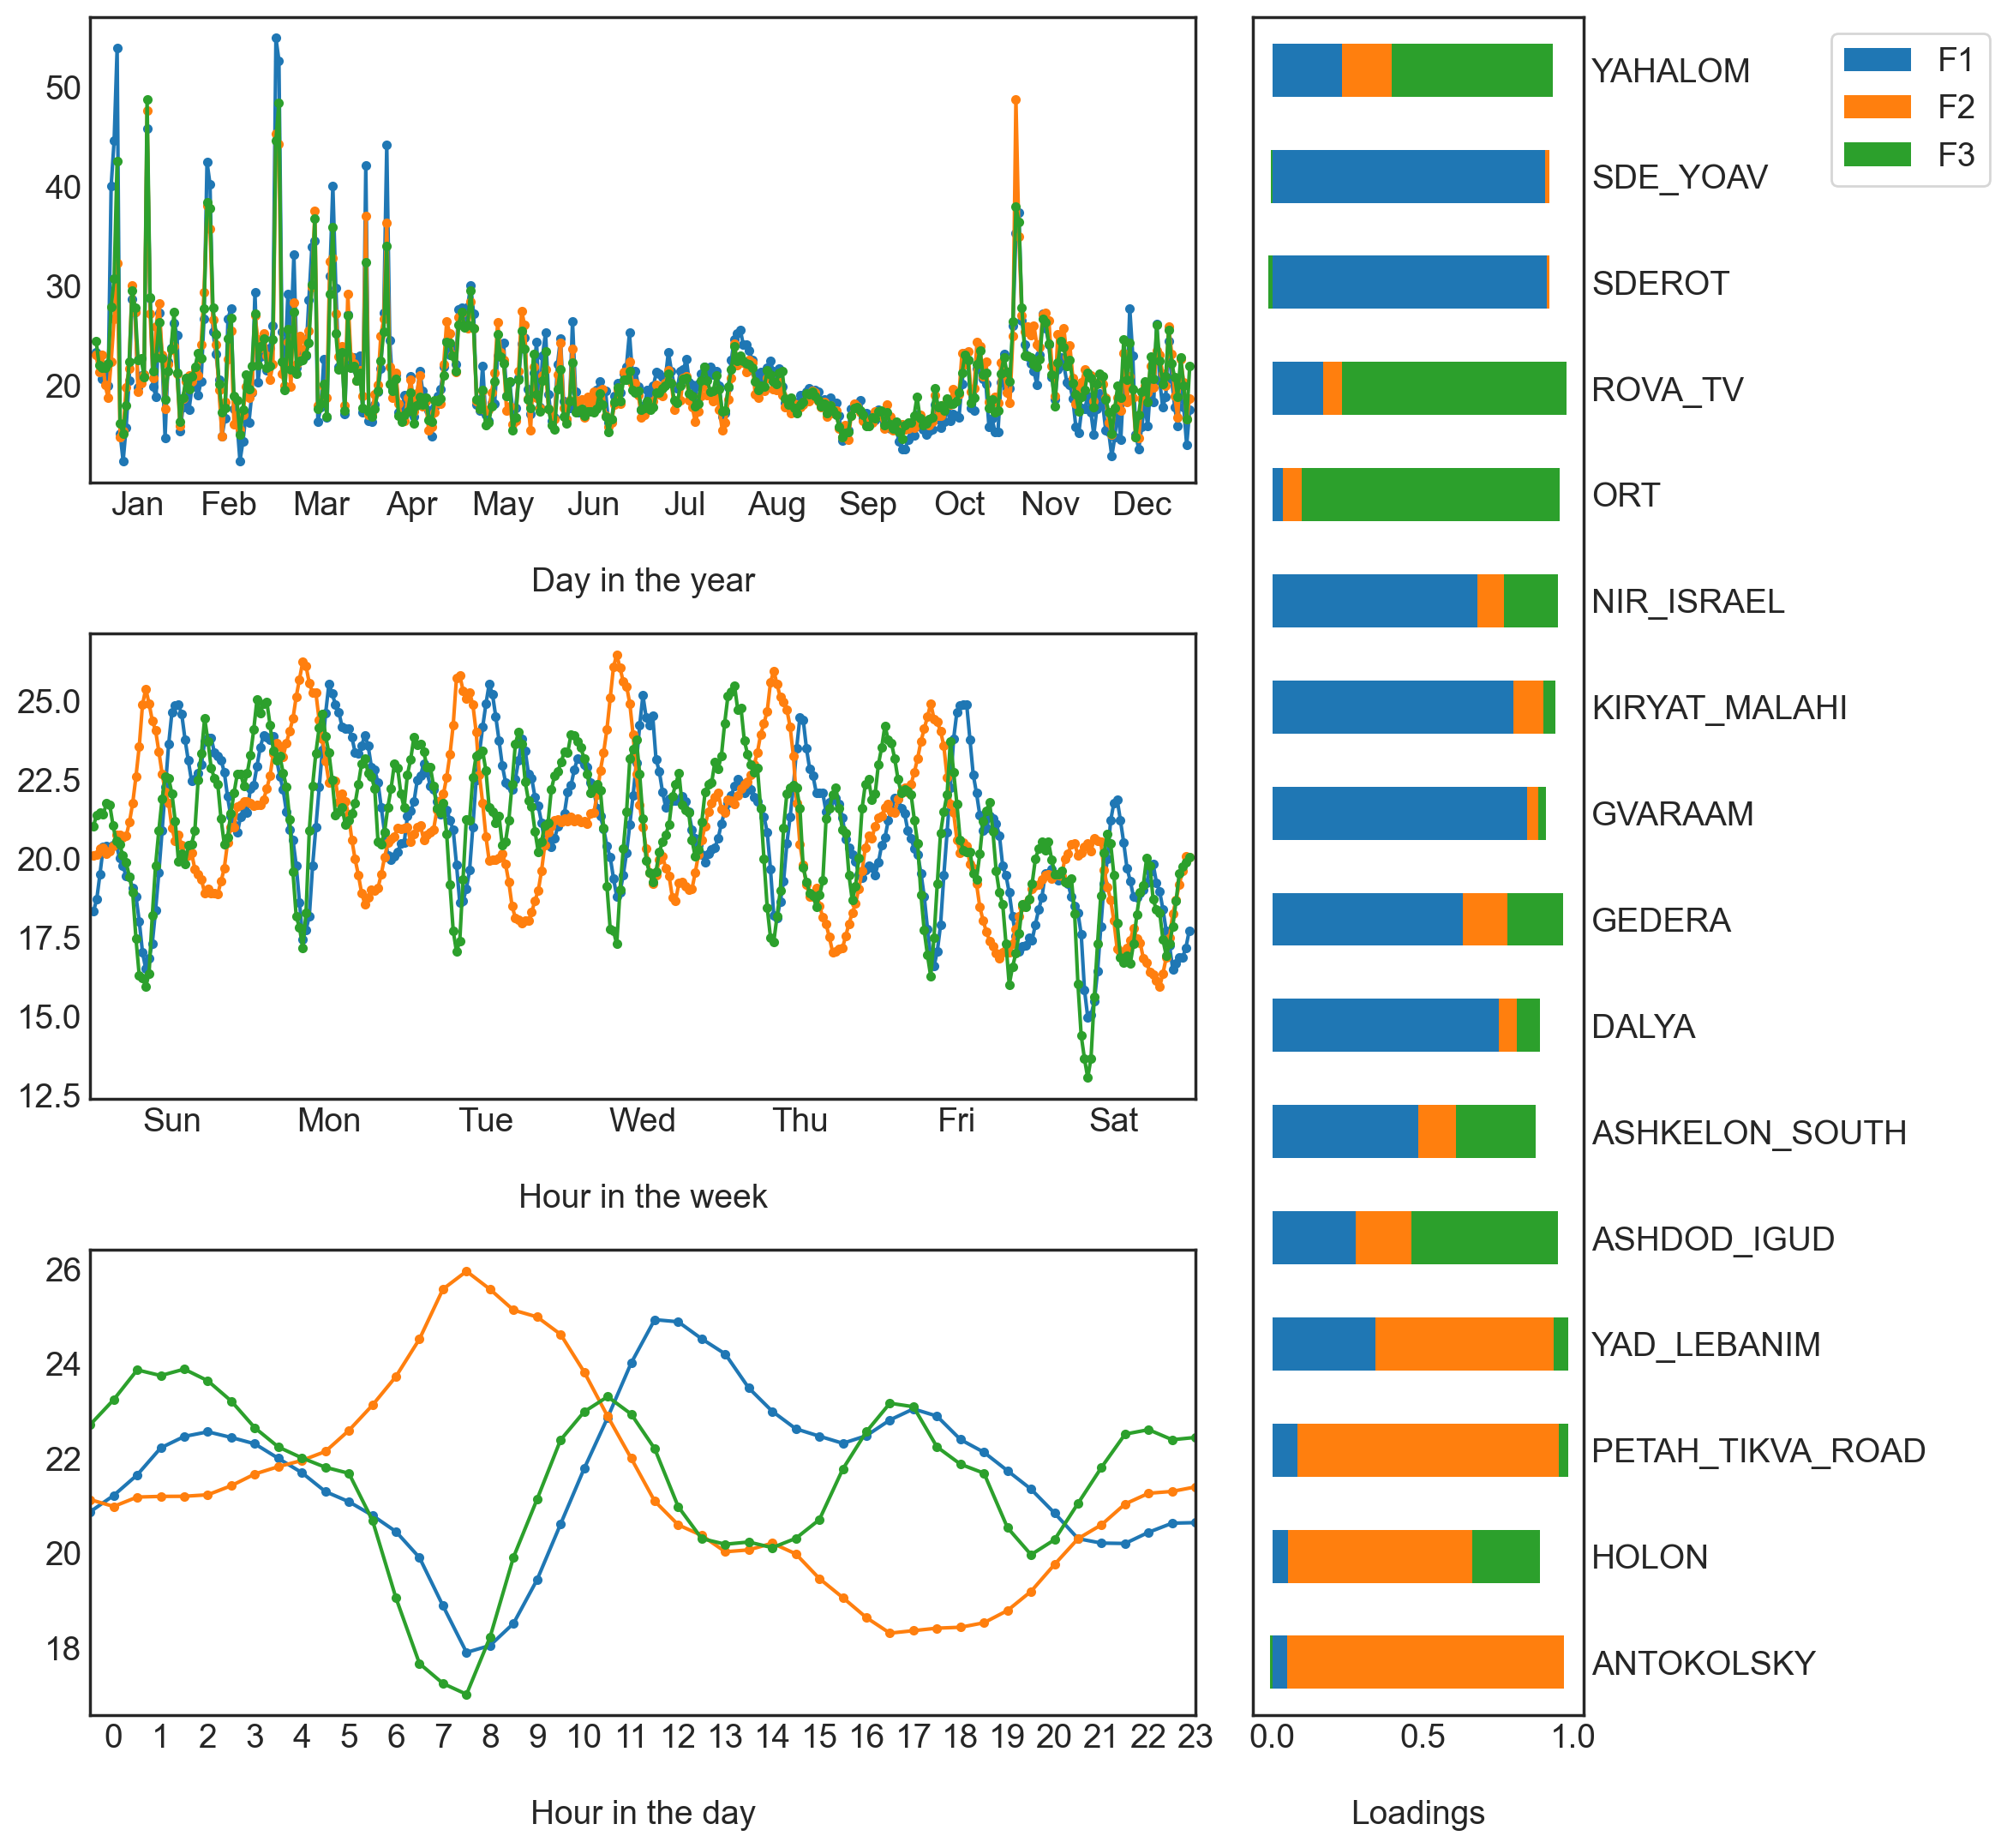

In [1006]:
df_scores = add_group_columns_to_df_scores(df_scores,times)
to_save = False
plot_factors_and_loadings(df_scores, df_load, list_of_factors, column_names, weekend_removed, to_save)

In [1007]:
# Add units in the y axis

In [1008]:
times.iloc[np.argmax(F[0,:])]

time    2013-04-01 14:30:00
Name: 21917, dtype: object

In [1009]:
# https://www.israelhayom.co.il/article/81351

In [1010]:
reconstructed = np.dot(df_load,F).T

In [1011]:
# report standardized residuals since each station has its ows mean and std. 

In [1012]:
# residulas = (observed - predicted)/std((observed - predicted))
r = df.values - reconstructed
# std_r = (r)/(np.std(r,axis = 0))

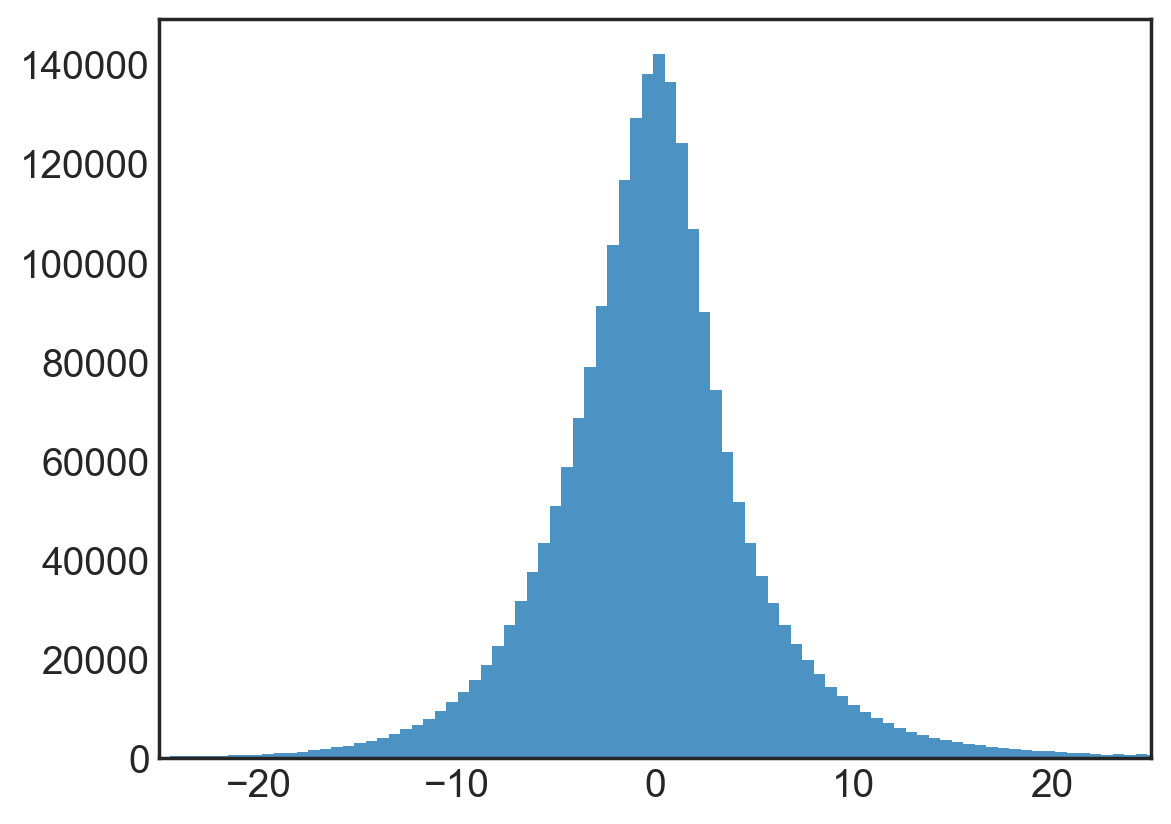

In [1013]:
plt.hist(r.flatten(),alpha = 0.8,bins=3000);
plt.xlim([-25,25]);

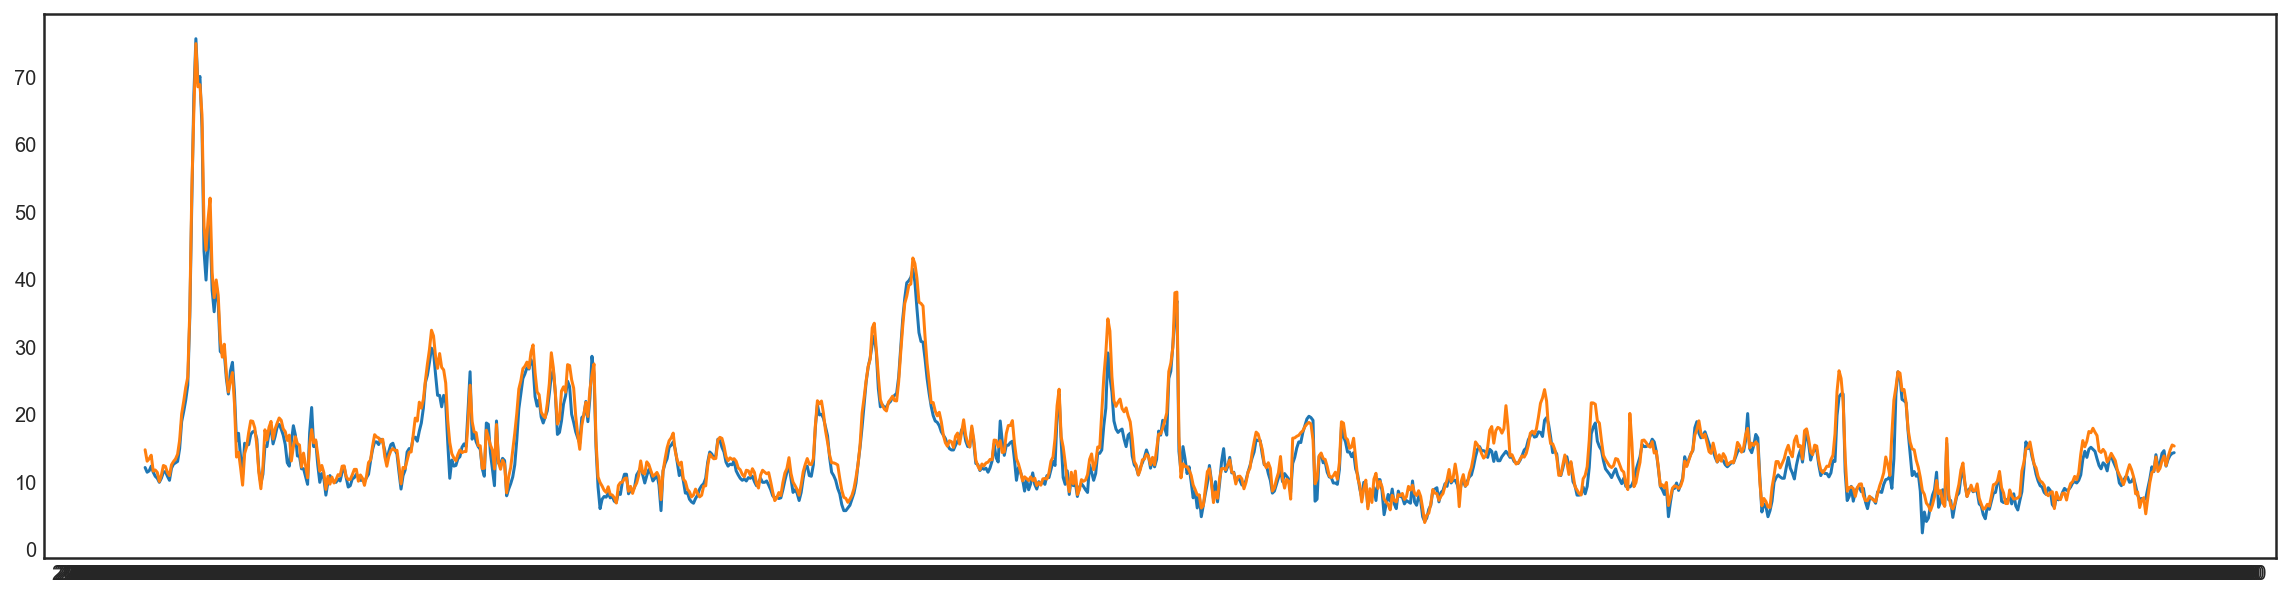

In [1014]:
%matplotlib inline

ax, fig = plt.subplots(figsize = (20,5))

plt.plot(times.iloc[:1000].time,df.iloc[:1000,0])
plt.plot(times.iloc[:1000].time,reconstructed[:1000,0])

# Look at the factors and hope for good

In [1018]:
Z0 = np.dot(np.transpose(df_load.iloc[:,0].values.reshape(1,-1)),df_scores.iloc[:,0].values.reshape(1,-1))
Z1 = np.dot(np.transpose(df_load.iloc[:,1].values.reshape(1,-1)),df_scores.iloc[:,1].values.reshape(1,-1))
Z2 = np.dot(np.transpose(df_load.iloc[:,2].values.reshape(1,-1)),df_scores.iloc[:,2].values.reshape(1,-1))
# Z3 = np.dot(np.transpose(df_load.iloc[:,3].values.reshape(1,-1)),df_scores.iloc[:,3].values.reshape(1,-1))

In [1019]:
# # in case I want to plot the scaled concentrations. no reason for that I think.
# Z0 = np.dot(np.transpose(Loadings[:,0].reshape(1,-1)),scores[:,0].reshape(1,-1))
# Z1 = np.dot(np.transpose(Loadings[:,1].reshape(1,-1)),scores[:,1].reshape(1,-1))
# Z2 = np.dot(np.transpose(Loadings[:,2].reshape(1,-1)),scores[:,2].reshape(1,-1))
# Z3 = np.dot(np.transpose(Loadings[:,3].reshape(1,-1)),scores[:,3].reshape(1,-1))

In [1020]:
# Z = np.dstack([Z0,Z1,Z2,Z3])
Z = np.dstack([Z0,Z1,Z2])

In [1021]:
Z.shape

(16, 139824, 3)

In [1022]:
factorsSelect = widgets.Select(
    options=np.arange(len(list_of_factors)),
    value=1,
    description='Factor',
    disabled=False
)

stationsSelect = widgets.Select(
    options=list(df.columns.values),
    description='Station',
    value = 'ANTOKOLSKY',
    disabled=False
)

slider_xlim = widgets.IntSlider(
    min=10,
    max=100,
    step=5,
    value=30
)

@interact(stations=stationsSelect, variables=factorsSelect, xlim=slider_xlim)

def f(stations, variables, xlim):
    plt.hist(Z[np.argwhere(df.columns==stations)[0][0],:,variables].flatten(),alpha = 0.8,bins=700);
    plt.xlim([-1,xlim]);

interactive(children=(Select(description='Station', options=('ANTOKOLSKY', 'HOLON', 'PETAH_TIKVA_ROAD', 'YAD_LEBANIM', 'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'DALYA', 'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM'), value='ANTOKOLSKY'), Select(description='Factor', index=1, options=(0, 1, 2), value=1), IntSlider(value=30, description='xlim', min=10, step=5), Output()), _dom_classes=('widget-interact',))

In [30]:
# Z[np.argwhere(df.columns=='ATZMAUT_B')[0][0],:,2]

In [31]:
# df_Z2 = pd.DataFrame(Z2.T,columns = df.columns)

In [32]:
# ind_to_start = np.argwhere(np.array([times.time == str(2017)+'-01-01 00:30:00']))[0][1]
# df_Z2 = df_Z2.iloc[ind_to_start:,]
# df_Z2.reset_index(inplace=True,drop=True)

In [33]:
# df_Z2.to_pickle('~/Documents/Broday/saved_data_from_notebooks/TRAFFIC_FA')

# NMF

In [248]:
# NUM = 3
# weekend_removed = False
# list_of_factors = ['Factor'+str(i+1) for i in range(NUM)]

In [205]:
# rs = 0#100

In [792]:
# W, H, n_iter = non_negative_factorization(df, n_components=NUM, init='nndsvd', random_state=rs, max_iter=2000)
# # init = 'nndsvd' - better for sparse matrix 
# # 'random' = matrices are scaled with: sqrt(X.mean() / n_components)
# # "Ideally H will be somewhat sparse -- you would like to measure species that are, if not unique to a source, at least specific to a group of sources"
# W.shape
# H.shape
# n_iter

In [207]:
# column_names = df.columns

In [208]:
# df_load = pd.DataFrame(H.T,columns=list_of_factors)
# df_scores = pd.DataFrame(W, columns=list_of_factors)

In [209]:
# # scaling
# df_scores = np.max(df_load.max())*df_scores
# df_load = df_load/np.max(df_load.max())

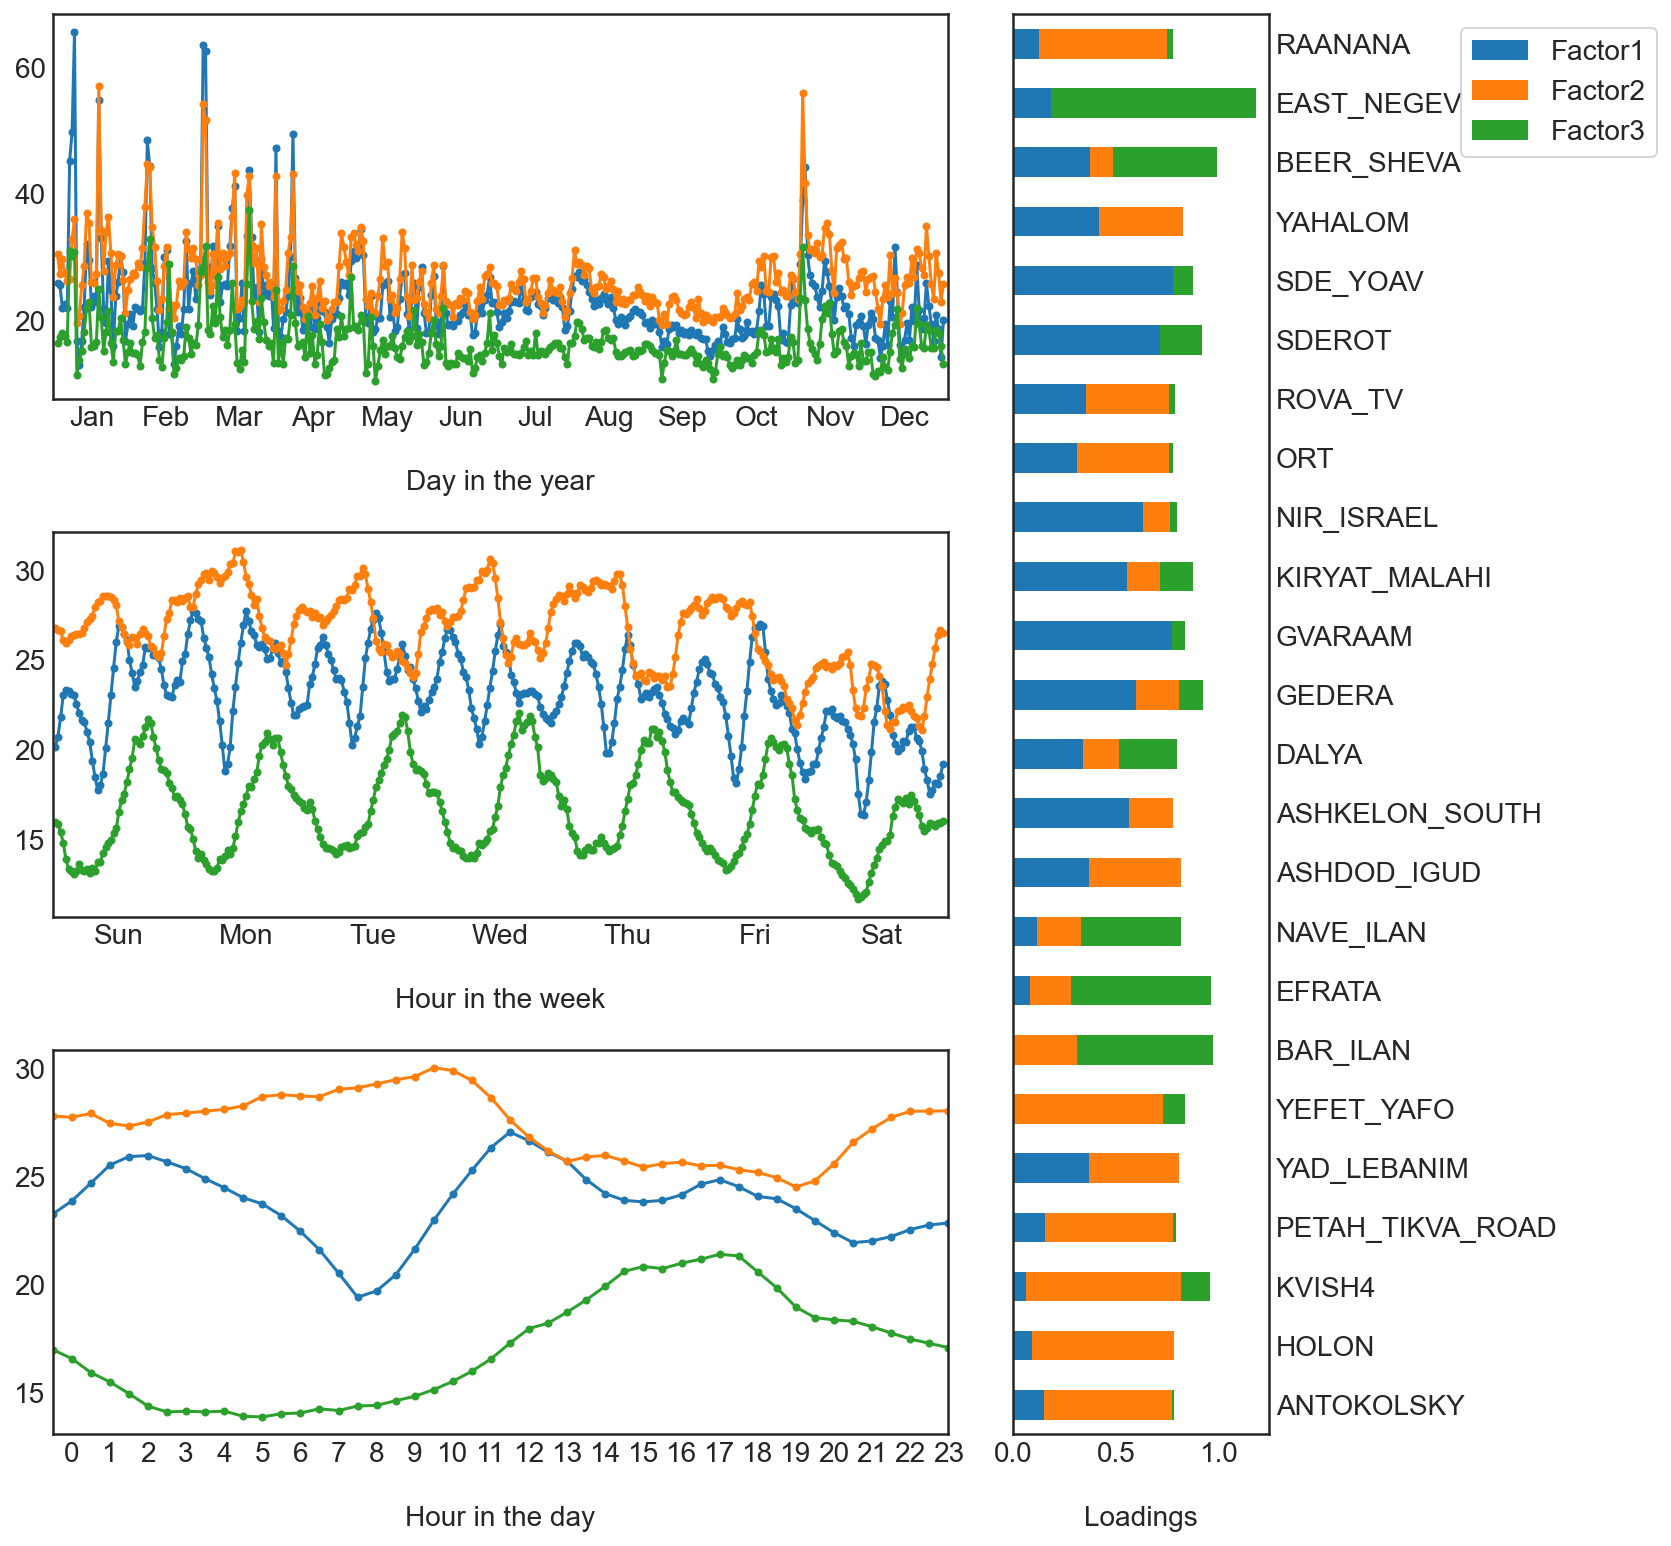

In [210]:
# df_scores = add_group_columns_to_df_scores(df_scores,times)

# to_save = False
# plot_factors_and_loadings(df_scores, df_load, list_of_factors, column_names, weekend_removed, to_save)

In [41]:
# CONCLUSIONS:
# promax gives similar results to MNF, but when the contribution in a station is zero then it cannot give zero, it gives negative 
# contributions instead (does that mean that NMF is over estimating or FA underestimating?)
# Varimax on the other hand just gives a negative tail to everyone. 
# So maybe promax with ignoring stations that give negative contribution to traffic will work.
# OR just refer to it as PCA and look at negative Vs. positive

# FA maps

In [1023]:
import metpy as mp
import metpy.calc as mpcalc
from metpy.units import units
from IPython import display
import matplotlib as mpl
import matplotlib.animation as manimation
from scipy import stats
import time
mpl.use("Agg")

In [1024]:
# plt.rcParams['animation.ffmpeg_path'] = '/Users/iditbela/Documents/Broday/saved_data_from_notebooks/ffmpeg'

In [1025]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

InteractiveShell.ast_node_interactivity = "last_expr"

In [1026]:
# import wind data for stations

In [1027]:
# data_df = pd.read_csv('/Users/iditbela/Documents/Broday/saved_data_from_notebooks/data_df', index_col = [0,1])
times_df = pd.read_pickle('/Users/iditbela/Documents/Broday/saved_data_from_notebooks/times_df')
times_df.drop(idx_to_drop,axis = 0, inplace=True)
times_df.reset_index(inplace=True)

In [1028]:
times['day of week'] = times_df['day of week']

In [1029]:
df_WD = pd.DataFrame([],columns = df.columns)
df_WS = pd.DataFrame([],columns = df.columns)
df_met_WD = pd.DataFrame([],columns = df.columns)
df_met_WS = pd.DataFrame([],columns = df.columns)

In [1030]:
for st in df.columns:
    df_WD[st] = data_df.loc[st].WD.values
    df_WS[st] = data_df.loc[st].WS.values
    df_met_WD[st] = data_df.loc[st].met_WD.values
    df_met_WS[st] = data_df.loc[st].met_WS.values

In [1031]:
# unite WS, WD with met_WS and met_WD
df_WD[df_WD.isnull()] = df_met_WD[df_WD.isnull()]
df_WS[df_WS.isnull()] = df_met_WS[df_WS.isnull()]

In [1032]:
# ! remove 2015 storms from wind data
df_WD.drop(idx_to_drop,axis = 0, inplace=True)
df_WS.drop(idx_to_drop,axis = 0, inplace=True)

In [1033]:
df_WD.shape
df_WS.shape

(139824, 16)

In [1034]:
for f in list_of_factors:    
    stations[f]=np.nan

In [1035]:
# making it blue and red 

In [1036]:
days_in_week = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

In [1037]:
# cm = sns.color_palette(None, len(list_of_factors))
# cmap = sns.color_palette("coolwarm", as_cmap=True)
# cmap = sns.choose_colorbrewer_palette("coolwarm", as_cmap=True)

In [1038]:
# these are stations that do not perticipate in each factor and so they have negative concentrations. I currently 
# remove them from analysis. 
stations.Name[(Z.mean(axis=1)<0)[:,0]]
stations.Name[(Z.mean(axis=1)<0)[:,1]]
stations.Name[(Z.mean(axis=1)<0)[:,2]]
# stations.Name[(Z.mean(axis=1)<0)[:,3]]

0     ANTOKOLSKY
29        SDEROT
30      SDE_YOAV
Name: Name, dtype: object

In [1039]:
# colors should be according to above or below the mean for the station, 
# so should add a colomn of concentration minuse the mean concentration for that factor and that station
# However, I want the daily averages of the weekdays. 
factor_means = np.mean(Z,axis=1)
factor_stds = Z.std(axis=1)

In [1040]:
factor_stds
# factor_means

array([[ 1.03755795, 15.79745036,  0.11907145],
       [ 1.09715067, 10.53610569,  4.146176  ],
       [ 1.76769676, 14.92775278,  0.57716474],
       [ 7.28628648, 10.17160305,  0.8718686 ],
       [ 5.86481691,  3.19088944,  8.93900077],
       [10.29918046,  2.18152182,  4.82785897],
       [15.96990582,  1.06992591,  1.39536055],
       [13.46507544,  2.51239405,  3.41008415],
       [17.99034316,  0.62968957,  0.46141619],
       [17.00665053,  1.70061289,  0.76933677],
       [14.4544776 ,  1.5376882 ,  3.31302264],
       [ 0.77637396,  1.05720779, 15.72503412],
       [ 3.58927414,  1.09878747, 13.64796482],
       [19.37693153,  0.13622743,  0.26658332],
       [19.23491629,  0.25078383,  0.08102064],
       [ 4.9203929 ,  2.8324064 ,  9.81871668]])

In [1041]:
df.columns

Index(['ANTOKOLSKY', 'HOLON', 'PETAH_TIKVA_ROAD', 'YAD_LEBANIM', 'ASHDOD_IGUD',
       'ASHKELON_SOUTH', 'DALYA', 'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI',
       'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV', 'YAHALOM'],
      dtype='object')

In [1042]:
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = manimation.FFMpegWriter(fps=15, metadata=metadata)

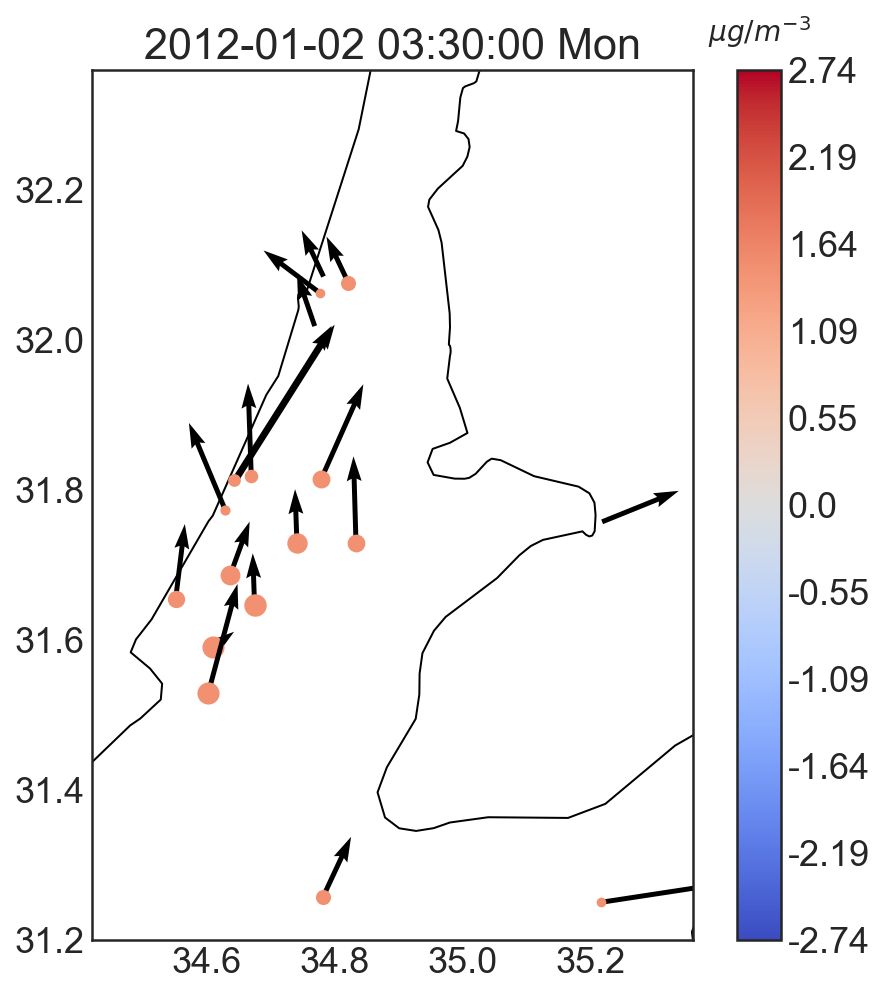

KeyboardInterrupt: 

<Figure size 576x576 with 0 Axes>

In [867]:
# NOTE THAT THE PROJECTION IS WRONG. SHOULD BE PRESENTED IN TRAVERSE MERCATOR ISRAELI ITM. 
factor = 0
scale = 10 # the plot is per factor, might need to change the scale of the circles 
n_std = 1
t_start = 0 #36320 #36335 #66100 # A good example for traffic - 36320

for t in range(t_start,len(times)): 
    
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df_geo = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    
#     fig = plt.figure()
#     ax = fig.add_axes([0, 0, 1, 1])
    ax = gdf.plot(figsize=(8, 8), color='w',edgecolor='k')

    for st in df.columns:
        # preper data
        # turn to U and V components
        U,V = mpcalc.wind_components(df_WS[st].values[t]* units('m/s'),df_WD[st].values[t]* units.deg)
#         for factor in range(len(list_of_factors)):
        f_mean = factor_means[stations.Name==st,factor]
        if f_mean>0:
            stations.loc[stations.Name==st,list_of_factors[factor]] = Z[stations.Name==st,t,factor].flatten()-factor_means[stations.Name==st,factor]
          
        # plot it
        plt.quiver(stations[stations.Name==st].Lon.values, stations[stations.Name==st].Lat.values, U, V, units='xy',scale = 30, width=0.007); #,headwidth=2

#         factor = 3
        vmin=-n_std*factor_stds[stations.Name==st,factor]*scale
        vmax=n_std*factor_stds[stations.Name==st,factor]*scale
#         vmin=-5
#         vmax=5
        scatter = plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st][list_of_factors[factor]].values[0]*scale), c=stations[stations.Name==st][list_of_factors[factor]].values[0]*scale,cmap='coolwarm',vmin=vmin,vmax=vmax)
    
    
    cbar = plt.colorbar(scatter)
#     factor = 3
    
    mn=-n_std*factor_stds[stations.Name==st,factor] # 2 stds #notice the station the std is taken for is the last one (RAANANA. NOT GOOD SINCE IT IS NEGATIVE)
    mx=n_std*factor_stds[stations.Name==st,factor]   
#     mn=-5 
#     mx=5
    
    num_ticks = 11
    ticks = np.linspace(mn*scale, mx*scale, num_ticks)
    labels = np.round(np.linspace(mn, mx, num_ticks),2)
    
    cbar.set_ticks(ticks.flatten())    
    cbar.set_ticklabels(labels.flatten())  
    cbar.ax.set_title('$\mu g/m^{-3}$',pad=14, size=14)


#     #make a legend:
#     pws = [0, 3, 5, 7, 20]
#     for pw in pws:
#     plt.scatter([], [], s=(pw**2)*5, c="b",label=str(pw))

#     h, l = plt.gca().get_legend_handles_labels()
#     plt.legend(h[1:], l[1:], labelspacing=1.2, title="petal_width", borderpad=1, 
#             frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

#     # produce a legend with a cross section of sizes from the scatter
#     handles, labels = scatter.legend_elements(prop="sizes",num=6)
#     legend = ax.legend(handles, labels, bbox_to_anchor=[1.35, 1], title="Sizes")
    
#     plt.legend(*scatter.legend_elements("sizes", num=6),loc="upper right", title="Sizes")

    # plot concentrations
    # df_geo.plot(kind='scatter', x='Lon', y='Lat', s=df_geo['F1'])    
    # df_geo.plot(markersize=df_geo['F1'])

    plt.ylim(31.2,32.36)
    plt.xlim(34.42,35.36)
    plt.title(times.time[t]+ ' ' + days_in_week[int(times['day of week'][t])-1])
    plt.rcParams.update({'font.size': 18})
    display.clear_output(wait=True) 
    display.display(plt.gcf())
    
#     with writer.saving(fig, "writer_test.mp4", 100):
#         writer.grab_frame()
    
#     time.sleep(1)
    plt.close()

    # plt.axis('equal')

In [ ]:
# strong westerlies in April are weakening the traffic factor?
# maybe add rain for that half hour to see if influences. 
# I think it would be good to remove outliers like Lag Baomer and Yom Kipur from analysis. 

# Polar plots for factors

In [1043]:
def plot_polar(x,y,z,vmin,vmax):
    
    binx = np.linspace(0,2*np.pi)
    biny = np.linspace(0, 24, num=24)
    ret = stats.binned_statistic_2d(x, y, z, statistic=np.nanmedian, bins=[binx, biny])
#     print(ret.statistic.T.shape)
#     print(ret.statistic.T)

    Theta, R = np.meshgrid(binx[:], biny[:]) # not sure about this (removed the -1)
    # Theta.shape
    # R.shape

    cmap = plt.get_cmap('cool')
    fig, ax = plt.subplots(subplot_kw={"projection":"polar"},figsize = (7,7))
    PC = ax.pcolormesh(Theta, R, ret.statistic.T,cmap=cmap,vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(PC)

    ax.grid(True)
#     if met:
#         title = 'wind data from nearest met station'
#     else:
#         title = 'wind data from the AQM station'
#     ax.set_title(title)
    plt.show();
     

In [1065]:
st = 'ASHDOD_IGUD'
# st = 'ANTOKOLSKY'
factor = 2

In [1066]:
x = df_WD[st].values*2*np.pi/360 
y = df_WS[st].values
z = Z[stations.Name==st,:,factor].flatten()

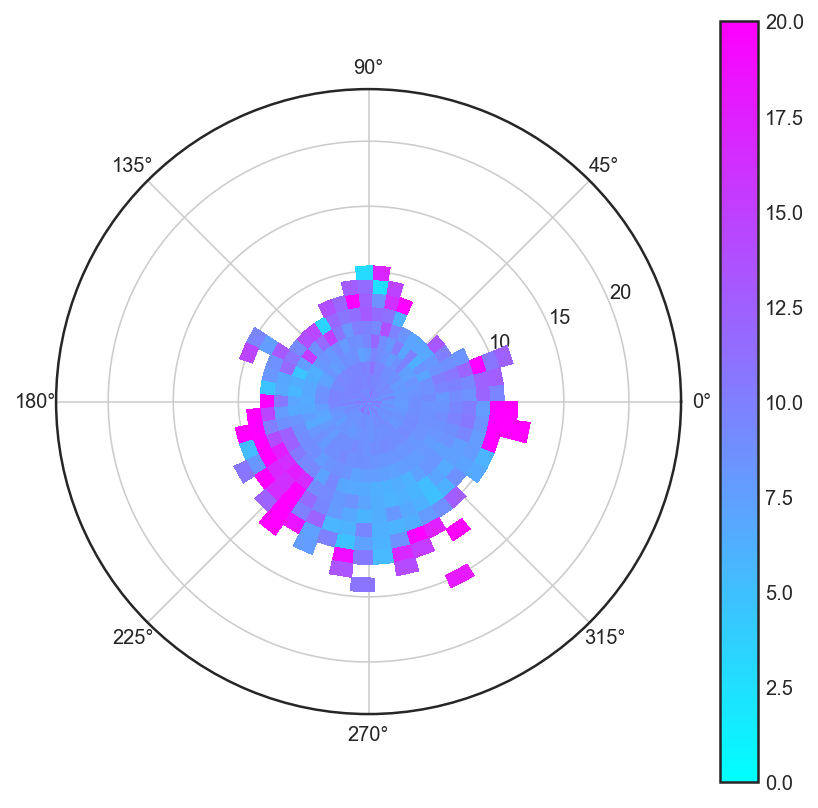

In [1067]:
plot_polar(x,y,z,0,20)

# FA ML

In [944]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error #=mean error (Simon 2012)
from sklearn.metrics import r2_score

In [945]:
# functions

# take only chosen vars and then drop vars with 100% null. 
# maybe should combine between met and stations variables. 

def get_sub_df(data_df,times_df, st, CHOSEN_VARS, idx_to_drop):
    
    temp_df = data_df.loc[st].reset_index(0,drop=True)
    temp_times = times_df.copy()
    temp_df.drop(temp_df.index[idx_to_drop], inplace=True)
    temp_df.reset_index(inplace=True)

    temp_df['holidays'] = temp_times['holidays'].values
    temp_df['hour'] = temp_times['hour'].values
    temp_df['day of week'] = temp_times['day of week'].values
    temp_df['day in year'] = temp_times['day in year'].values      


    # (No need to drop from times_df if dropped earlier)
#     temp_times.drop(idx_to_drop,axis = 0, inplace=True)    
#     temp_times.reset_index(inplace=True)

    temp_times.drop(labels = 'index',axis=1, inplace=True)
    
#     temp_df.drop(VARS_TO_DROP,axis=1,inplace=True)

    temp_df = temp_df.iloc[:,temp_df.columns.isin(CHOSEN_VARS)]
    
    # try first the met. values measured in the AQM station and if absent then replace with 
    # nearest station. 
    temp_df.loc[temp_df['WD'].isnull(),'WD'] = temp_df.loc[temp_df['WD'].isnull(),'met_WD'].values
    temp_df.loc[temp_df['WS'].isnull(),'WS'] = temp_df.loc[temp_df['WS'].isnull(),'met_WS'].values
    temp_df.loc[temp_df['StWD'].isnull(),'StWD'] = temp_df.loc[temp_df['StWD'].isnull(),'met_StWD'].values
    temp_df.loc[temp_df['Temp'].isnull(),'Temp'] = temp_df.loc[temp_df['Temp'].isnull(),'met_Temp'].values
    temp_df.loc[temp_df['RH'].isnull(),'RH'] = temp_df.loc[temp_df['RH'].isnull(),'met_RH'].values
    temp_df.loc[temp_df['Rain'].isnull(),'Rain'] = temp_df.loc[temp_df['Rain'].isnull(),'met_Rain'].values
    temp_df.loc[temp_df['SR'].isnull(),'SR'] = temp_df.loc[temp_df['SR'].isnull(),'met_SR'].values
#     temp_df.loc[temp_df['BP'].isnull(),'BP'] = temp_df.loc[temp_df['BP'].isnull(),'met_BP'].values
    
    # remove columns with only nans
    VARS_TO_DROP = temp_df.columns[(temp_df.isnull().sum()/temp_df.shape[0]).values == 1.0].values   
    temp_df.drop(VARS_TO_DROP,axis=1,inplace=True)
    
    # remove met columns after completing the data
    VARS_TO_DROP = ['met_WD','met_WS', 'met_StWD', 'met_Temp', 'met_RH', 'met_Rain', 'met_SR','met_BP','SR']
    if st=='BEER_SHEVA':
        VARS_TO_DROP = ['met_WD','met_WS', 'met_StWD', 'met_Temp', 'met_RH', 'met_Rain', 'met_SR','met_BP','SR','CO', 'Benzene', 'Toluene']
     
    
    temp_df.drop(VARS_TO_DROP,axis=1,inplace=True)
    
    print(100*temp_df.isnull().sum()/temp_df.shape[0])
    
    return temp_df


def get_vars_for_xgboost(temp_df,Z,factor,st,remove_nan):
       
    X = temp_df.values

    Y = Z[stations.Name==st,:,factor].flatten()
    
    if remove_nan:
        # in case I want to remove all rows with a feature of nan. 
        X = pd.DataFrame(X, columns=temp_df.columns.values)

        Y = Y[(~X.isnull()).all(axis=1)]
        X = X[(~X.isnull()).all(axis=1)]

        X = X.values

    print(Y.shape)
    print(X.shape)
    
    return X, Y

def get_vars_for_xgboost_PM25(temp_df,remove_nan):
    
    Y = temp_df['PM25'].values
    temp_df.drop('PM25',axis=1,inplace=True)
    X = temp_df.values    
    
    if remove_nan:
        # in case I want to remove all rows with a feature of nan. 
        X = pd.DataFrame(X, columns=temp_df.columns.values)

        Y = Y[(~X.isnull()).all(axis=1)]
        X = X[(~X.isnull()).all(axis=1)]

        X = X.values

    print(Y.shape)
    print(X.shape)
    
    return X, Y
    
    
def get_permutation_plot(featureNames, model, X_test,y_test, n_repeats, score, test_rmse, to_save):
    
    # train and test gives the same results! I think by definition it is done on the train
    dtrain = xgb.DMatrix(X_test, label=y_test, feature_names=featureNames)

    # neg_root_mean_squared_error
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, scoring=score,random_state=42) # (default is r2), neg_mean_absolute_error, neg_root_mean_squared_error

    sorted_idx = perm_importance.importances_mean.argsort()

    # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
    fig, ax = plt.subplots(figsize=(10, 10))
    if score == 'neg_root_mean_squared_error':
        ax.boxplot(perm_importance.importances[sorted_idx].T/test_rmse,
                   vert=False, labels=np.array(dtrain.feature_names)[sorted_idx])
        ax.set_xlabel('\n$RMSE-ratio$')
        
    if score == 'r2':
        ax.boxplot(perm_importance.importances[sorted_idx].T,
                   vert=False, labels=np.array(dtrain.feature_names)[sorted_idx])
        ax.set_xlabel('\n$R^2$')

     
    ax.set_title("Permutation Importances (test set)")
    
    fig.tight_layout()
    
    if to_save:
        plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/permutation_importances.png", dpi=500)
    plt.show();
    
    
def get_correlations_to_factor(X,Y,featureNames):
    
    spearman_results = []
    for i in range(np.shape(X)[1]):        
        spearman_results.append(stats.spearmanr(X[:,i],Y)[0])
    
    spearman_results = pd.DataFrame(spearman_results,index=featureNames,columns=['Spearman_corr'])
    
    return spearman_results



In [946]:
times_df['hour']= times_df['hour'].astype(str)

In [947]:
# I removed PM10 since it is very correlative with PM2.5. NOT SURE. 
CHOSEN_VARS = ['O3', 'NO', 'NO2', 'NOx', 'SO2', 'WD', 'WS', 'StWD', 'Temp',#'PM10',
       'RH', 'Rain', 'CO', 'Benzene', 'Toluene', 'SR', 'BP', 'met_WD',
       'met_WS', 'met_StWD', 'met_Temp', 'met_RH', 'met_Rain', 'met_SR',
       'met_BP', 'private', 'truck', 'bus', 'blh', 'ssrd'
#                ,'חברת חשמל תחנת הכח רוטנברג, אשקלון',
#         'חברת חשמל תחנת הכח צפית'
              ]

In [844]:
# print: station, xgboost results, np.sum([Y<0])

In [982]:
# factor = 2

# st = 'KIRYAT_BIALIK'

# print(st)
# temp_df = get_sub_df(data_df,times_df, st, CHOSEN_VARS, idx_to_drop)
# X,Y = get_vars_for_xgboost(temp_df,Z,factor,st,remove_nan)
# print(np.sum([Y<0]))

# X_train, X_test, y_train, y_test = train_test_split(np.squeeze(X), Y, test_size=test_size, random_state=seed)

# # it stops after 100 iterations because this is the default number... 
# # model = XGBRegressor(importance_type = 'gain', num_parallel_tree=20, n_estimators=100, max_depth=4,reg_alpha=0,reg_lambda = 4.5) #learning_rate = 0.29) # try hist and gpu_hist in tree_method
# model = XGBRegressor() #learning_rate = 0.29) # try hist and gpu_hist in tree_method
# model.fit(X_train, y_train) #, early_stopping_rounds=10)

# y_pred = model.predict(X_test)
# y_pred_train = model.predict(X_train)

# R2 = r2_score(y_train, y_pred_train)
# print( 'train R2 is: ' + str(R2))

# R2 = r2_score(y_test, y_pred)
# print( 'test R2 is: ' + str(R2))

In [846]:
# with 4 factors and traffic stations:

# factor 1 (NO PM10)
# PETAH_TIKVA_ROAD - need to work on the model
# ASHDOD_IGUD
# ASHKELON_SOUTH

# run also with substituing met_BP.
# YEFET_YAFO
# BAR_ILAN

# try with PM10?
# PETAH_TIKVA_ROAD
# YAD_LEBANIM
# BAR_ILAN

# factor 2 (NO PM10)
# BAR_ILAN
# EFRATA

# factor 2 (with PM10)
# PETAH_TsIKVA_ROAD
# YAD_LEBANIM
# BAR_ILAN
# EAST_NEGEV

# factor 3 ( bad :/)
# ASHKELON_SOUTH
# DALYA
# GEDERA?

# with power plants (looks like it improves everything, so should be suspecious!):
# ASHDOD_IGUD
# ANTOKOLSKY
# ASHKELON_SOUTH
# DALYA


# with 3 factors and no traffic stations:

# factor 0
# PETAH_TIKVA_ROAD (?)
# ASHDOD_IGUD
# ASHKELON_SOUTH
# DALYA
# GEDERA

# factor 1 - traffic
# PETAH_TIKVA_ROAD
# ASHDOD_IGUD
# ASHKELON_SOUTH (?)

# factor 2
# DALYA?


In [950]:
factor = 2
remove_nan = True
seed = 0
test_size = 0.2

for st in df.columns:
    print(st)
    temp_df = get_sub_df(data_df,times_df, st, CHOSEN_VARS, idx_to_drop)
    X,Y = get_vars_for_xgboost(temp_df,Z,factor,st,remove_nan)
    print(np.sum([Y<0]))
    if len(Y) == 0:
        continue
        
    X_train, X_test, y_train, y_test = train_test_split(np.squeeze(X), Y, test_size=test_size, random_state=seed)

    # it stops after 100 iterations because this is the default number... 
    # model = XGBRegressor(importance_type = 'gain', num_parallel_tree=20, n_estimators=100, max_depth=4,reg_alpha=0,reg_lambda = 4.5) #learning_rate = 0.29) # try hist and gpu_hist in tree_method
    model = XGBRegressor() #learning_rate = 0.29) # try hist and gpu_hist in tree_method
    model.fit(X_train, y_train) #, early_stopping_rounds=10)

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    R2 = r2_score(y_train, y_pred_train)
    print( 'train R2 is: ' + str(R2))

    R2 = r2_score(y_test, y_pred)
    print( 'test R2 is: ' + str(R2))


ANTOKOLSKY
O3          7.214784
NO         16.472852
NO2        16.530782
NOx        16.558674
SO2         5.953913
WD          0.519939
WS          0.490617
StWD        0.489902
Temp        2.686949
RH          2.614716
Rain        0.467731
private     0.000000
truck       0.000000
bus         0.000000
blh         0.000000
ssrd        0.000000
dtype: float64
(113841,)
(113841, 16)
112900
[00:12:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train R2 is: 0.17781601321349494
test R2 is: 0.12108430702032336
HOLON
NO         6.752775
NO2        6.678396
NOx        6.754205
WD         0.011443
WS         0.011443
StWD       0.032899
Temp       0.003576
RH         0.010728
Rain       0.331846
private    0.000000
truck      0.000000
bus        0.000000
blh        0.000000
ssrd       0.000000
dtype: float64
(130230,)
(130230, 14)
1164
[00:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

train R2 is: 0.1711013055036925
test R2 is: 0.1328927870833595
SDE_YOAV
NO          5.827326
NO2         6.563251
NOx         6.733465
SO2        15.533814
WD          0.002861
WS          0.002146
StWD        0.002146
Temp        0.002861
RH          0.011443
Rain        0.009297
private     0.000000
truck       0.000000
bus         0.000000
blh         0.000000
ssrd        0.000000
dtype: float64
(113073,)
(113073, 15)
1086
[00:13:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train R2 is: 0.1834876479829598
test R2 is: 0.12638906398349425
YAHALOM
WD         91.579414
WS         91.579414
StWD       91.579414
Temp        1.019854
RH          3.705372
Rain        3.059561
private     0.000000
truck       0.000000
bus         0.000000
blh         0.000000
ssrd        0.000000
dtype: float64
(11772,)
(11772, 11)
115
[00:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squareder

# TRASH

In [120]:
# mpl.style.use('seaborn-white')
# #     cm = ['c','m','#d9534f','#9ad801']
# cm = sns.color_palette(None, len(list_of_factors))

In [890]:
# # NOTE THAT THE PROJECTION IS WRONG. SHOULD BE PRESENTED IN TRAVERSE MERCATOR ISRAELI ITM. 

# plt.ion
# # change the Coordinate Reference System (CRS)
# gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
# df_geo = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
# ax = gdf.plot(color='w',edgecolor='k')

# t = 70000
# for st in df.columns:
#     # preper data
#     # turn to U and V components
#     U,V = mpcalc.wind_components(df_WS[st].values[t]* units('m/s'),df_WD[st].values[t]* units.deg)
#     for factor in range(len(list_of_factors)):
#         stations.loc[stations.Name==st,list_of_factors[factor]] = Z[np.argwhere([stations.Name==st])[0][1],t,factor].flatten()

#     # plot it
#     plt.quiver(stations[stations.Name==st].Lon.values, stations[stations.Name==st].Lat.values, U, V, units='xy',scale = 30, width=0.007); #,headwidth=2
# #     df_geo.plot(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0], markersize=stations[stations.Name==st].F1.values[0]) 
# #     plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F1.values[0])*5,c=cm[0])
# #     plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F2.values[0])*5,c=cm[1])
# #     plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F3.values[0])*5,c=cm[2])
# #     plt.scatter(x=stations[stations.Name==st].Lon.values[0], y=stations[stations.Name==st].Lat.values[0],s=abs(stations[stations.Name==st].F4.values[0])*5,c=cm[3])

# # plot concentrations
# # df_geo.plot(kind='scatter', x='Lon', y='Lat', s=df_geo['F1'])    
# # df_geo.plot(markersize=df_geo['F1']) 

# plt.ylim(31.2,32.36)
# plt.xlim(34.42,35.36)
# plt.rcParams.update({'font.size': 14})
# plt.show();
# # plt.axis('equal')